This notebook shows how to transform a vector field in a flow map in google mercator projection.

In [2]:
# we need a few libraries

# for data
import netCDF4
# for computing
import numpy as np
# for numbers <-> colors
import matplotlib.colors
# for interpolation 
import scipy.interpolate
# for reprojection
import osr

# for plotting
import matplotlib.pyplot as plt


%matplotlib inline

In [3]:
# and vectors
ds = netCDF4.Dataset('/Users/baart_f/models/sfo/baydelta/dec1999_mar2000/DFM_OUTPUT_alcatraz/alcatraz_map.nc')

In [25]:
# take about 1 tidal cycle
# ucx and ucy are cell centered velocities
s = slice(230, -9)
ucx = ds.variables['ucx'][s,:]
ucy = ds.variables['ucy'][s,:]

24.1

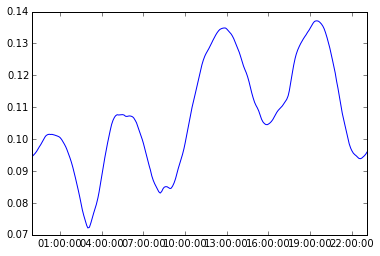

In [31]:
dates = netCDF4.num2date(ds.variables['time'][s], ds.variables['time'].units)
plt.plot(dates, np.mean(np.sqrt(ucx**2 + ucy**2), axis=1))
(dates[-1] - dates[0]).total_seconds()/3600.0

In [32]:
# these are the coordinates of the cell centers
xcc = ds.variables['FlowElem_xcc'][:]
ycc = ds.variables['FlowElem_ycc'][:]


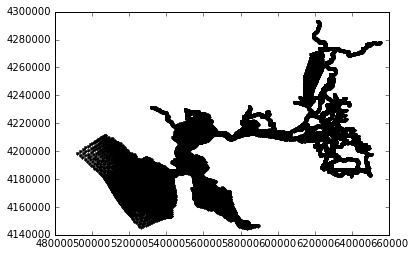

In [33]:
# let's see what we have
plt.plot(xcc, ycc, 'k.')


In [34]:
# We need to transfor between different coordinate systems
# The local coordinate system of the model, in this case UTM10n
# The spherical mercator that is used in web projections, 900913 (reads google, a joke from the OSM community), 
# or more formally (3857)
# We also need the WGS84 to specify our bounding box

# let's define the systems
src_srs = osr.SpatialReference()
src_srs.ImportFromEPSG(32610)
dst_srs = osr.SpatialReference()
dst_srs.ImportFromEPSG(900913)
wgs84 = osr.SpatialReference()
wgs84.ImportFromEPSG(4326)

# and the translations between them
src2wgs84 = osr.CoordinateTransformation(src_srs, wgs84)
dst2wgs84 = osr.CoordinateTransformation(dst_srs, wgs84)
src2dst = osr.CoordinateTransformation(src_srs, dst_srs)

print(src_srs.ExportToPrettyWkt())
print(dst_srs.ExportToPrettyWkt())

PROJCS["WGS 84 / UTM zone 10N",
    GEOGCS["WGS 84",
        DATUM["WGS_1984",
            SPHEROID["WGS 84",6378137,298.257223563,
                AUTHORITY["EPSG","7030"]],
            AUTHORITY["EPSG","6326"]],
        PRIMEM["Greenwich",0,
            AUTHORITY["EPSG","8901"]],
        UNIT["degree",0.0174532925199433,
            AUTHORITY["EPSG","9122"]],
        AUTHORITY["EPSG","4326"]],
    PROJECTION["Transverse_Mercator"],
    PARAMETER["latitude_of_origin",0],
    PARAMETER["central_meridian",-123],
    PARAMETER["scale_factor",0.9996],
    PARAMETER["false_easting",500000],
    PARAMETER["false_northing",0],
    UNIT["metre",1,
        AUTHORITY["EPSG","9001"]],
    AXIS["Easting",EAST],
    AXIS["Northing",NORTH],
    AUTHORITY["EPSG","32610"]]
PROJCS["Google Maps Global Mercator",
    GEOGCS["WGS 84",
        DATUM["WGS_1984",
            SPHEROID["WGS 84",6378137,298.257223563,
                AUTHORITY["EPSG","7030"]],
            AUTHORITY["EPSG","6326"]],
        PRI

In [35]:
# convert our points to google map coordinates
points_gm = np.array(src2dst.TransformPoints(np.c_[xcc, ycc]))

In [36]:
# We want velocities in pixels/s in our target coordinate system

# We thus need to know how wide each pixel is in the  target system

# We also have to take into account that 1 meter in utm10n does not correspond to 
# 1 meter in web mercator. 
# The web mercator is not very accurate, it is not a conformal projection.

# One way to correct for this is to compute a correction factor for each point

# compute the local distortion 
# how many meters is 1 meter in the projected system, given x,y
x_plus_half = np.array(src2dst.TransformPoints(np.c_[xcc + 0.5, ycc]))
x_minus_half = np.array(src2dst.TransformPoints(np.c_[xcc - 0.5, ycc]))
y_plus_half = np.array(src2dst.TransformPoints(np.c_[xcc, ycc + 0.5]))
y_minus_half = np.array(src2dst.TransformPoints(np.c_[xcc, ycc - 0.5]))

# compute the deformation factor
x_distort = (x_plus_half - x_minus_half)[:,0]
y_distort = (y_plus_half - y_minus_half)[:,1]



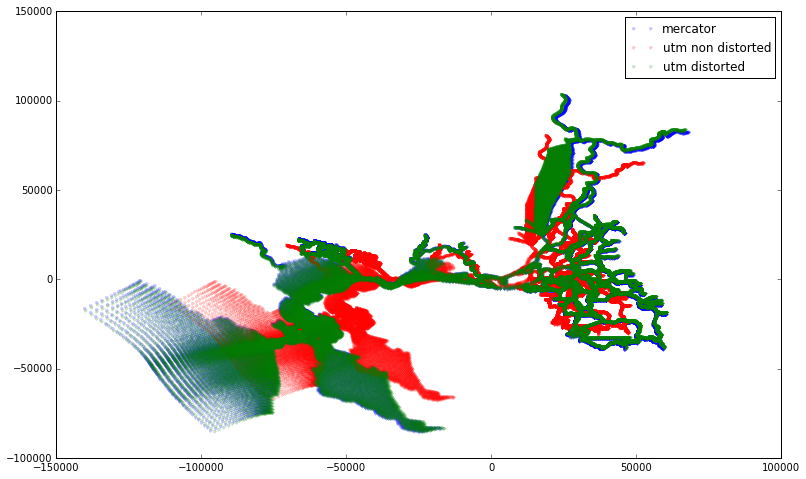

In [37]:
# check if these velocities match up, somewhat...
# See http://www.hydrometronics.com/downloads/Web%20Mercator%20-%20Non-Conformal,%20Non-Mercator%20(notes).pdf
# for details
fig, ax = plt.subplots(figsize=(13,8))
points_gm_central = (points_gm - points_gm.mean(axis=0))
points_utm_central = np.c_[xcc,ycc] - np.c_[xcc,ycc].mean(axis=0)
ax.plot(points_gm_central[:,0], points_gm_central[:,1], 'b.', label='mercator', alpha=0.2)
ax.plot(points_utm_central[:,0] , points_utm_central[:,1] , 'r.', label='utm non distorted', alpha=0.2)
ax.plot(points_utm_central[:,0] * x_distort, points_utm_central[:,1] * y_distort, 'g.', label='utm distorted', alpha=0.2)
ax.legend()

In [38]:
# create an interpolation function that gives us velocities at each point in the domain.
# in this case we use a triangulated interpolation, which isn't optimal, but ok for now

# Create an interpolation function to map the velocities in web mercator projection
F = scipy.interpolate.LinearNDInterpolator(
    points_gm[:,:2], 
    np.c_[
        ucx[-1,:] * x_distort, 
        ucy[-1,:] * y_distort
    ]
)
F.fill_value = 0.0

In [39]:
# now create a map in google mercator
xmin = F.points[:,0].min()
xmax = F.points[:,0].max()

ymin = F.points[:,1].min()
ymax = F.points[:,1].max()

# we want a big map as the base layer. 
nx = 1024
ny = 1024

x = np.linspace(xmin, xmax, num=nx)
y = np.linspace(ymin, ymax, num=ny)

X, Y = np.meshgrid(x, y)

ll = dst2wgs84.TransformPoint(x[0], y[0])
ur = dst2wgs84.TransformPoint(x[-1], y[-1])
# this is the bounding box that we need for adding the map
# should this be plus 1 cell?
ll, ur

((-123.09234894317646, 37.4487848675731, 0.0),
 (-121.2218887213739, 38.780310596186474, 0.0))

In [92]:
# todo: create a mask based on cell contours
# mask everything further than 1000m from nearest point
tree = scipy.spatial.cKDTree(points_gm[:,:2])
pts = np.c_[X.ravel(), Y.ravel()]
distances, indices = tree.query(pts, distance_upper_bound=2000.0)
maskdist = np.isinf(distances).reshape(X.shape)

In [106]:
import skimage.draw
import skimage.filter
import skimage.morphology
isgrid = np.zeros((ny, nx), dtype='bool')
x_contour = ds.variables['FlowElemContour_x'][:]
y_contour = ds.variables['FlowElemContour_y'][:]
netCDF4.Dataset('/Users/baart_f/models/sfo/baydelta/dec1999_mar2000/alcatrazr15_net.nc').variables['NetElemNode'][:]
n_points = (ds.variables['NetElemNode'][:]>0).sum(1)

xmin = x[0]
xrange = x[-1] - x[0]
ymin = y[0]
yrange = y[-1] - y[0]

for x_coords, y_coords, n_points in zip(x_contour, y_contour, n_points):
    contour = np.array(src2dst.TransformPoints(np.c_[x_coords[:n_points], y_coords[:n_points]]))
    x_contour = nx * (contour[:,0] - xmin)/xrange
    y_contour = ny * (contour[:,1] - ymin)/yrange
    #y_contour = ny * (ymax - contour[:,1])/yrange
    rr, cc = skimage.draw.polygon(y_contour, x_contour, isgrid.shape)
    isgrid[rr, cc] = True
# want to dilate the grid a bit so colors will run through
mask = ~skimage.morphology.dilation(isgrid, skimage.morphology.square(5))


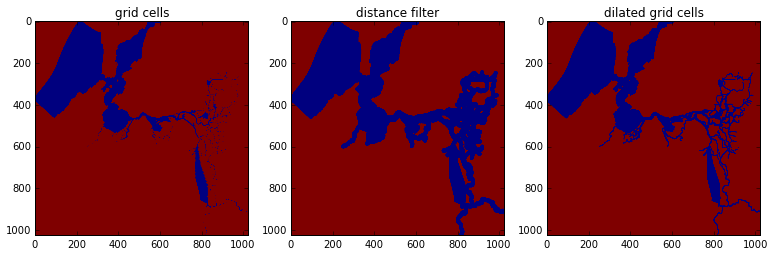

In [101]:
fig, ax = plt.subplots(1,3, figsize=(13,6))

# thes
ax[0].imshow(~isgrid)
ax[0].set_title('grid cells')
ax[1].imshow(maskdist)
ax[1].set_title('distance filter')
ax[2].imshow(~skimage.morphology.dilation(isgrid, skimage.morphology.square(5)))
ax[2].set_title('dilated grid cells')


In [110]:
for i in range(ucx.shape[0]):
    values = np.c_[
        ucx[i,:] * x_distort, 
        ucy[i,:] * y_distort
    ]
    # add new values to the interpolation function
    F.values = values
    # compute the u, v points
    uv = F(np.c_[X.ravel(), Y.ravel()])
    # unpack
    u, v = uv.T
    # clip and scale to 0,1
    clip = 5.0
    N = matplotlib.colors.Normalize(vmin=-clip, vmax=clip)
    # reshape and mask
    U = np.ma.masked_array(u.reshape(X.shape), mask).filled(0)
    V = np.ma.masked_array(v.reshape(X.shape), mask).filled(0)
    # create u,v,mask,0 image in range 0, 255
    UV = np.zeros(shape=(nx, ny, 4), dtype='uint8')
    UV[:,:,0] = (N(U) * 255.0).astype('uint8')
    UV[:,:,1] = (N(V) * 255.0).astype('uint8')
    UV[:,:,2] = (mask).astype('uint8')
    UV[:,:,3] = 255
    # save each frame
    plt.imsave('im_{:04d}.png'.format(i), UV)
    
